# Team Lovelace : #TODO (ecrire le titre) <img src="../Data/Images/LinkedIn_logo_initials.png" width="25">

Welcome to our project notebook for Milestone P2! In this phase, our team has worked on refining our project proposal and conducting preliminary analyses to set the stage for a successful data exploration and analysis journey. 

Our project aims to analyze the careers of actors present in our dataset. In this milestone, we delve into initial analyses and data handling tasks, ensuring that our proposed project is feasible given the available datasets.

## Imports


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from tqdm import tqdm
from rapidfuzz import fuzz

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%load_ext autoreload
%autoreload 2

## Loading Datasets

In [2]:
# Setting the paths to the data folders
DATA_FOLDER = "../Data/"
CMU_PATH = DATA_FOLDER + "MovieSummaries/"
IMDB_PATH = DATA_FOLDER + "IMDb/"
OMDB_PATH = DATA_FOLDER + "OMDb/"
BUDGET_PATH = DATA_FOLDER + "Budget/"
OSCARS_PATH = DATA_FOLDER + "Oscars/"

# Reading CMU Movie & Character metadata
cmu_movies_raw = pd.read_csv(CMU_PATH + "movie.metadata.tsv", sep="\t", )
cmu_characters_raw = pd.read_csv(CMU_PATH + "character.metadata.tsv", sep="\t")

# Reading IMDb basics and ratings data
imdb_movies_raw = pd.read_csv(
    IMDB_PATH + "title.basics.tsv.gz", sep="\t", compression="gzip"
)
imdb_ratings_raw = pd.read_csv(
    IMDB_PATH + "title.ratings.tsv.gz", sep="\t", compression="gzip"
)

# Reading movie data that was fetched using the OMDb API (done in omdbAPI.ipynb)
omdb_raw = pd.read_csv(
    OMDB_PATH + "omdb.csv"
)

# Reading movie budget data
budget_raw = pd.read_csv(
    BUDGET_PATH + "movies_metadata.csv.zip", compression="zip",
)

# Reading Oscars data
oscars_raw = pd.read_csv(
    OSCARS_PATH + "the_oscar_award.csv",
)


# TODO Import other dataset (Don't forget to add comments as above)

### Renaming Columns

Both CMU datasets, `cmu_movies_raw` and `cmu_characters_raw`, initially lacked column names (#TODO ajouter les noms des autres datasets entre `...` si nécessaires). To address this, we have provided names in the cell below. For the CMU dataset, you can refer to the descriptions of each column [here](http://www.cs.cmu.edu/~ark/personas/). (#TODO pareil mettre les liens pour les autres datasets)


In [3]:
cmu_movies_raw.columns = [
    "wikiID",
    "fbID",
    "movieName",
    "releaseDate",
    "boxOffice",
    "runtime",
    "languages",
    "countries",
    "genres",
]

cmu_characters_raw.columns = [
    "wikiID",
    "fbID",
    "releaseDate",
    "characterName",
    "actorDOB",
    "actorGender",
    "actorHeight",
    "actorEthnicity",
    "actorName",
    "ageAtMovieRelease",
    "fbCharacterMap",
    "fbCharacterID",
    "fbActorID",
]

cmu_movies_raw.drop(columns="wikiID", inplace=True)  #TODO expliquer pk on drop au dessus
cmu_characters_raw.drop(columns="wikiID", inplace=True)
#TODO add les noms ici si necessaire pour les autres datasets

To ensure consistency in column names across datasets, we have renamed some columns in the other datasets (to match the conventions of the CMU dataset) in the cell below.

In [4]:
imdb_movies_raw.rename(
    columns={
        "tconst": "imdbID",
        "primaryTitle": "movieName",
        "startYear": "releaseYear",
        "runtimeMinutes": "runtime",
    },
    inplace=True
)

imdb_ratings_raw.rename(
    columns={
        "tconst": "imdbID",
    },
    inplace=True
)

oscars_raw.rename(
    columns={
        "year_film": "releaseYear",
        "year_ceremony": "yearCeremony",
        "name": "actorName",
        "film": "movieName",
    },
    inplace=True
)

omdb_raw = omdb_raw[
    ['Rated', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster', 'Ratings', 'Metascore',
     'imdbID']].rename(
    columns={
        "Rated": "MPARating",
        "Director": "director",
        "Writer": "writer",
        "Actors": "actors",
        "Plot": "plot",
        "Language": "languages",
        "Country": "countries",
        "Awards": "awards",
        "Poster": "poster",
        "Ratings": "allRatings",
        "Metascore": "metascore",
    }
)

budget_raw = budget_raw[["budget", "popularity", "imdb_id"]].rename(
    columns={
        "imdb_id": "imdbID",
    }
)

# TODO rename les columns des autres datasets si nécessaire

In [5]:
budget_raw

,budget,popularity,imdbID
0,30000000,21.946943,tt0114709
1,65000000,17.015539,tt0113497
2,0,11.7129,tt0113228
3,16000000,3.859495,tt0114885
4,0,8.387519,tt0113041
...,...,...,...
45461,0,0.072051,tt6209470
45462,0,0.178241,tt2028550
45463,0,0.903007,tt0303758
45464,0,0.003503,tt0008536


## Merging Datasets

Before merging the datasets, it is important to clean and standardize the column formats for the columns we intend to merge on. To facilitate this process, we create copies of our raw dataframes. This ensures that we don't need to reload them if we want to start the cleaning process from scratch.

In [6]:
cmu_movies = cmu_movies_raw.copy()
cmu_characters = cmu_characters_raw.copy()

imdb_movies = imdb_movies_raw.copy()
imdb_ratings = imdb_ratings_raw.copy()

omdb = omdb_raw.copy()

budget = budget_raw.copy()

oscars = oscars_raw.copy()

### Cleaning columns `movieName` & `actorName`

#TODO Michael explain why et comment tu le fais pour les deux datasets cmu movies et imdb et autres

In [7]:
# pre-filtering IMDb movies
# keep only movies and shorts
imdb_movies = imdb_movies[imdb_movies['titleType'].isin(['movie', 'short', 'tvMovie', 'tvShort'])]
# remove data for movies with no name
imdb_movies.dropna(subset='movieName', inplace=True)

In [8]:
# standardize movie titles by removing accents, special characters, extra spaces and converting to lowercase
cmu_movies['movieName'] = cmu_movies['movieName'].apply(standardize_str)
imdb_movies['movieName'] = imdb_movies['movieName'].apply(standardize_str)

In [9]:
# cleaning titles #TODO #dans oscars

### Cleaning column `releaseDate`

The `cmu_movies` and `cmu_characters` dataset exhibit variable date formats, with some entries providing day, month, and year, while others only contain the year. To enhance clarity and facilitate analysis, we've decided to split the `releaseDate` column into separate columns for `releaseMonth` and `releaseYear`. In contrast, the `imdb_movies` and `oscars` datasets provides release dates in the year-only format.

In [10]:
# Cmu movies & characters
# Months
cmu_movies["releaseMonth"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", dayfirst=True
).dt.month
cmu_characters["releaseMonth"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", yearfirst=True
).dt.month
# Year
cmu_movies["releaseYear"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year
cmu_characters["releaseYear"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year

# Drop releaseDate column
cmu_movies.drop(columns=["releaseDate"], inplace=True)
cmu_characters.drop(columns=["releaseDate"], inplace=True)

# IMDb & Oscars
imdb_movies["releaseYear"] = pd.to_datetime(
    imdb_movies["releaseYear"], errors="coerce", format="%Y"
).dt.year

oscars["releaseYear"] = pd.to_datetime(
    oscars["releaseYear"], errors="coerce", format="%Y"
).dt.year

In [11]:
# drop movie with same title and release date to avoid issues when merging
cmu_movies.drop_duplicates(subset=["movieName", "releaseMonth", "releaseYear"], inplace=True)
imdb_movies.drop_duplicates(subset=["movieName", "releaseYear"], inplace=True)

### Cleaning column `runtime`

The `runtime` column for the `imdb_movies` dataset contains '\N' values instead of 'NaN'.

In [12]:
imdb_movies["runtime"] = pd.to_numeric(imdb_movies["runtime"], errors="coerce")

#TODO other columns to clean pour merger??

### Cleaning budget dataset

In [13]:
# Make sure all budget entries are numeric (or null)
budget["budget"] = pd.to_numeric(budget["budget"], errors="coerce")
# Remove duplicate IMDb IDs
budget.drop_duplicates(subset='imdbID', inplace=True)
# Replace all zero budget entries to nan
budget.loc[budget['budget'] == 0, 'budget'] = np.nan
# Drop null budget and imdbID entries to avoid issues when merging
budget.dropna(subset=['budget', 'imdbID'], inplace=True)

### Merging

In the following cell, we perform two left merges:

1. **CMU Movies and IMDb Merged Data:**
   - We merge the `cmu_movies` dataset with the merged IMDb dataset based on the common columns `["movieName", "releaseYear", "runtime"]`. The resulting DataFrame, named `movies_merged`, contains combined information from both datasets, with column suffixes "Cmu" for columns from the CMU dataset and "Imdb" for columns from the IMDb dataset.
<br>
<br>
2. **CMU Characters and Oscars:**
   - We merge the `cmu_characters` dataset with the `oscars` dataset based on the common columns `["actorName", "releaseYear", "movieName"]` using a left join.
   

#TODO other merge to do. Adapter les textes au dessus et il faut max deux datasets. un qui s'appelle actors et l'autre movies




In [14]:
# Merging IMDb movies with IMDb ratings
imdb = pd.merge(imdb_movies, imdb_ratings, how='left', on='imdbID')

In [15]:
# Merging CMU movies with IMDb movies

# Using rapidfuzz library to perform fast fuzzy matching between the movie titles
# Group the imdb dataframe by releaseYear to speed up the search
grouped_imdb = imdb.groupby('releaseYear')
# Enable tqdm pandas integration
tqdm.pandas(desc="Retrieving best matches")
# Compute the best match for each title in CMU movies with a similarity threshold of 95
cmu_movies['matched_title'] = cmu_movies.progress_apply(get_best_match, args=(grouped_imdb,), scorer=fuzz.WRatio,
                                                        threshold=95, axis=1)

# Perform the merge on the matched titles and releaseYear
movies_merged = pd.merge(cmu_movies, imdb, left_on=['matched_title', 'releaseYear'],
                         right_on=['movieName', 'releaseYear'], how='left', suffixes=['Cmu', 'Imdb'])

# To improve the accuracy of the merge, we filter out IMDb data for movies where runtime doesn't match (with tolerance)
runtime_tol = 5  # Allow for 5 minutes of leeway in runtime between IMDb and CMU

# When only one of the runtimes is nan, use the other
movies_merged['runtimeCmu'] = np.where(
    # If runtimeCmu is nan but runtimeImdb is not, use runtimeImdb else keep runtimeCmu
    pd.isna(movies_merged['runtimeCmu']) & pd.notna(movies_merged['runtimeImdb']),
    movies_merged['runtimeImdb'],
    movies_merged['runtimeCmu']
)

# Identify rows where both runtimes are not NaN and the difference is not within tolerance
mask = pd.notna(movies_merged['runtimeCmu']) & pd.notna(movies_merged['runtimeImdb']) & (
        abs(movies_merged['runtimeCmu'] - movies_merged['runtimeImdb']) > runtime_tol)

# Remove IMDb data when the runtimes are not within tolerance
movies_merged.loc[mask, ['imdbID', 'titleType', 'originalTitle', 'isAdult', 'endYear', 'genresImdb', 'averageRating',
                         'numVotes']] = np.nan

# Drop extra columns used during title and runtime matching
movies_merged.drop(['matched_title', 'movieNameImdb', 'runtimeImdb'], axis=1, inplace=True)
movies_merged.rename(columns={'movieNameCmu': 'movieName', 'runtimeCmu': 'runtime'}, inplace=True)

Retrieving best matches: 100%|██████████| 81626/81626 [10:08<00:00, 134.22it/s]


In [16]:
# Merging IMDb budget with the merged movies dataframe
movies_merged = pd.merge(movies_merged, budget, on='imdbID', how='left')

In [17]:
# Merging CMU Characters with Oscars
characters_merged = pd.merge(
    cmu_characters.merge(
        cmu_movies[["fbID", "movieName"]], how="left", on="fbID"
    ),  # add movieName in cmu_characters
    oscars,
    how="left",
    on=["actorName", "releaseYear", "movieName"],
)

As before, we copy our DataFrame to avoid running the merge cell in case we make modifications incorrectly and wish to restart from this point.

In [21]:
movies = movies_merged.copy()
characters = characters_merged.copy()

Given that our analysis primarily centers on actors rather than movies characters, we construct a new dataframe `actors` from `characters` emphasizing actor-related information. The columns are rearranged to provide a perspective centered on actors. Following this, we filter out rows without a Freebase actor ID, as they only contain character information without actor-related details.

In [22]:
actors = characters[
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
        "fbID",
        "ageAtMovieRelease",  #TODO Adrien had cleaned this (there are negative ages!)
        "category",
        "winner",
    ]
]

actors = actors.sort_values(by=actors.columns.to_list(), ignore_index=True)
actors = actors.dropna(subset="fbActorID")

In [50]:
actors = actors.groupby(
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
    ],
    dropna=False
).apply(actors_agg).reset_index()  #ATTENTION TRES LONG #TODO remove cette remarque 

In [51]:
explode_on_movies(actors)

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/03qk61v,44.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/047dv64,NaN,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/051wrdv,35.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/06c5z_,33.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/06zm9p7,33.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0k3lpxc,46.0,None,None
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0kvf09,42.0,None,None
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0kvf6s,40.0,None,None
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0q9b0,32.0,None,None


In [90]:
print("MOVIES")
display(movies)
print("ACTORS")
display(actors)

MOVIES


,fbID,movieName,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes
0,/m/08yl5d,getting away with murder the jonbenet ramsey m...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2.0,2000.0,tt0245916,tvMovie,Getting Away with Murder: The JonBenet Ramsey ...,0,\N,Drama,6.0,69.0
1,/m/0crgdbh,brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,1988.0,tt0094806,movie,Brun bitter,0,\N,"Crime,Drama",5.6,40.0
2,/m/0285_cd,white of the eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",NaN,1987.0,tt0094320,movie,White of the Eye,0,\N,"Horror,Mystery,Thriller",6.1,2885.0
3,/m/01mrr1,a woman in flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",NaN,1983.0,tt0083949,movie,Die flambierte Frau,0,\N,Drama,6.0,621.0
4,/m/03cfc81,the gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",5.0,1913.0,tt0002894,short,The Gangsters,0,\N,"Comedy,Short",6.8,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81621,/m/0j7hxnt,mermaids the body found,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",3.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81622,/m/0g4pl34,knuckle,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",1.0,2011.0,tt1606259,movie,Knuckle,0,\N,"Biography,Documentary,Drama",6.8,3190.0
81623,/m/02pygw1,another nice mess,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",9.0,1972.0,tt0362411,movie,Another Nice Mess,0,\N,Comedy,5.8,110.0
81624,/m/03pcrp,the super dimension fortress macross ii lovers...,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",5.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ACTORS


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,/m/03q819,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,/m/03bkbh,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",NaN,NaN
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
135755,/m/0z58,Ardal O'Hanlon,M,1965-10-08,NaN,NaN,[/m/027cvd8],NaN,NaN,NaN
135756,/m/0z9q0,"José Luis Rodríguez ""El Puma""",M,1943-01-14,NaN,NaN,[/m/0gls5qd],{'/m/0gls5qd': 69.0},NaN,NaN
135757,/m/0zcb7,Marcus Giamatti,M,1961-10-03,1.850,NaN,"[/m/02drs7, /m/03b1xl, /m/047fs6w, /m/080kkcx,...","{'/m/02drs7': 40.0, '/m/03b1xl': 29.0, '/m/047...",NaN,NaN
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,"[/m/01510v, /m/01hv3t, /m/01pgnr, /m/024tb7, /...","{'/m/01510v': 31.0, '/m/01hv3t': 30.0, '/m/01p...",NaN,NaN


## NOM DE LA QUESTION SUR LES GENRES #TODO

## Cleaning the genres

The `genresCmu` column, while having very few missing values, exhibits a wide diversity of genres, as outlined in the cell below. Additionally, the genres are not standardized; for instance, we observe distinctions like 'Action', 'Adventure' and 'Action/Adventure' making it challenging to analyze. As for `genresImdb`, we have a reasonably manageable number of unique genres. However, due to the merge, we notice a considerable number of missing values compared to `genresCmu`.

In [53]:
# Updating the 'genresCmu' and 'genresImdb' columns to get a list of genres without the IDs for each movie
movies['genresCmu'] = movies['genresCmu'].apply(parse_dict)
movies['genresImdb'] = movies['genresImdb'].apply(
    lambda x: x.split(',') if not (isinstance(x, float) or x == "\\N") else np.nan)

In [54]:
percent_missing = movies.isnull().sum() * 100 / len(movies)
print(
    f"Proportion of missing values in each column:\n{percent_missing[['genresCmu', 'genresImdb']]}"
)

number_genres_cmu = len(movies.genresCmu.explode().unique())
number_genres_imdb = len(movies.genresImdb.explode().unique())
print("\nNumber of unique genres in\n" +
      "CMU:", number_genres_cmu, "\n"
                                 "Imdb:", number_genres_imdb)

Proportion of missing values in each column:
genresCmu      0.000000
genresImdb    39.524171
dtype: float64

Number of unique genres in
CMU: 365 
Imdb: 28


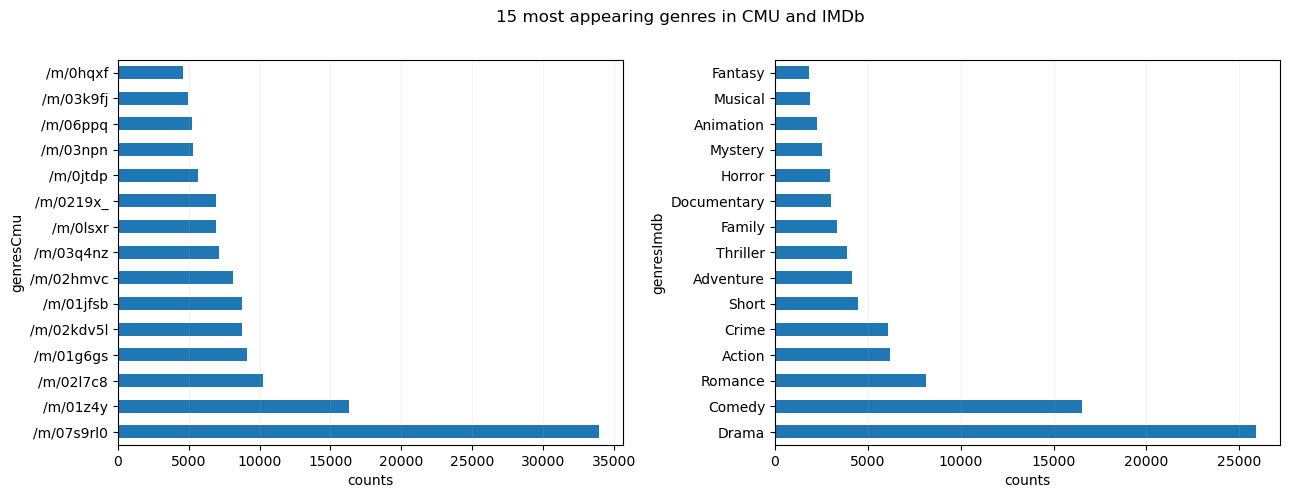

In [55]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle("15 most appearing genres in CMU and IMDb")

fig.add_subplot(121)
occurences_cmu = movies["genresCmu"].explode().value_counts()
occurences_cmu[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

fig.add_subplot(122)
occurences_imdb = movies["genresImdb"].explode().value_counts()
occurences_imdb[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

plt.subplots_adjust(wspace=0.3)

To address the issue of numerous missing values in 'Imdb' and the diversity of genres in 'CMU', we will first combine the genres for each movie.

In [56]:
combinedGenres = movies["genresImdb"].apply(
    lambda x: list(x) if isinstance(x, list) else []
) + movies["genresCmu"].apply(lambda x: list(x) if isinstance(x, list) else [])

combinedGenres = combinedGenres.apply(lambda x: set(x) if len(x) > 0 else np.nan)

movies["combinedGenres"] = combinedGenres
movies["combinedGenres"]

0                                {Drama}
1                         {Drama, Crime}
2            {Mystery, Horror, Thriller}
3                                {Drama}
4                        {Comedy, Short}
                      ...               
81621                                NaN
81622    {Biography, Drama, Documentary}
81623                           {Comedy}
81624                                NaN
81625                                NaN
Name: combinedGenres, Length: 81626, dtype: object

Once we have a set of unique genres for each movie, the idea is to create a long string by concatenating all the genres for all the movies.

In [95]:
genres = movies.dropna(subset="combinedGenres").explode(column="combinedGenres").combinedGenres.values
genres_str = " ".join(str(g) for g in genres)

genres_unique = np.unique(genres)

Then we want to split this long string using the `split_characters` found by the code. This will, for example, allow us to split the genre 'Action/Adventure' into 'Adventure' and 'Action'. The list `words` contains all the words appearing throughout all the combinedGenres. The more a word appears in the list `words`, the more it appears in combinedGenres.

In [96]:
split_characters = set()
for letter in genres_str:
    if (
            not letter.isalpha() and letter != " "
    ):  # letter.isalpha() return True if the letter is an alphabetic string
        split_characters.add(letter)

print(split_characters)

string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))

words = string.split(" ")
print("\nThe first 15 terms of the list words", words[:15])

{'9', '&', ']', '[', "'", '5', '-', '/'}

The first 15 terms of the list words ['Drama', 'Crime', 'Drama', 'Biographical', 'film', 'Mystery', 'Drama', 'Crime', 'Fiction', 'Crime', 'Thriller', 'Erotic', 'thriller', 'Psychological', 'thriller']


Now, our objective is to identify the most frequently occurring words in our list of `words`. As one can observe above, some words are presented in uppercase, while others are in lowercase. To ensure consistency, we convert all text to lowercase and proceed to identify words that appear more than 2000 times. 

In [97]:
words = list(map(lambda x: x.lower(), words))

counts = pd.Series(words).value_counts()
new_genres_serie = pd.Series(counts[counts > 2000])
new_genres_serie.index

Index(['drama', 'film', 'comedy', 'action', 'romance', 'crime', 'thriller',
       'adventure', 'fiction', 'short', 'black', 'and', 'white', 'family',
       'cinema', 'world', 'indie', 'horror', 'romantic', 'documentary',
       'silent', 'musical', 'movies', 'fantasy', 'animation', 'mystery', 'war',
       '', 'science', 'movie', 'western', 'japanese', 'biography'],
      dtype='object')

Finally, we have a list of words representing our new genres. After filtering out words that do not correspond to actual genres, we create a dictionary, `genres_dict`, linking genres from 'CMU' and 'IMDb' to our new list of genres. For example, all genres containing the word 'drama' will be associated with the genre 'Drama.' 

A list of genres associated with 'Drama' is displayed two cells below.

In [98]:
# Dropping irrelevant genres and characters from the series
new_genres_serie = new_genres_serie.drop(
    index=[
        "",
        "film",
        "cinema",
        "movie",
        "movies",
        "black",
        "and",
        "white",  # combining "black-and-white" instead of having separate entries
    ]
)

# Adding "black-and-white" to the indices
new_genres_serie["black-and-white"] = 0

# Capitalizing the new genres and create a list from the indices
new_genres = list(map(lambda x: x.capitalize(), new_genres_serie.index))

genres_dict = {genre: set() for genre in new_genres}
for new_genre in new_genres:
    for genre in genres_unique:
        if new_genre.lower() in genre.lower():
            genres_dict[new_genre].add(genre)

# Merging "Romantic" into "Romance" since can be considered equivalent
genres_dict["Romance"] = genres_dict["Romance"].union(genres_dict.pop("Romantic"))
new_genres.remove("Romantic")

print(len(new_genres), "unified genres listed below")
new_genres

25 unified genres listed below


['Drama',
 'Comedy',
 'Action',
 'Romance',
 'Crime',
 'Thriller',
 'Adventure',
 'Fiction',
 'Short',
 'Family',
 'World',
 'Indie',
 'Horror',
 'Documentary',
 'Silent',
 'Musical',
 'Fantasy',
 'Animation',
 'Mystery',
 'War',
 'Science',
 'Western',
 'Japanese',
 'Biography',
 'Black-and-white']

In [99]:
genres_dict["Drama"]

{'Addiction Drama',
 'Childhood Drama',
 'Comedy-drama',
 'Costume drama',
 'Courtroom Drama',
 'Crime Drama',
 'Docudrama',
 'Drama',
 'Erotic Drama',
 'Family Drama',
 'Fantasy Drama',
 'Historical drama',
 'Inspirational Drama',
 'Legal drama',
 'Marriage Drama',
 'Melodrama',
 'Musical Drama',
 'Political drama',
 'Romantic drama'}

In conclusion to the cleaning process, we apply the function `unify_genres()` to our column combinedGenres, creating the new unique column genres. This transformation ensures that the genres are now meaningful for our analysis.

Proportion of missing values in column genres 4.03%


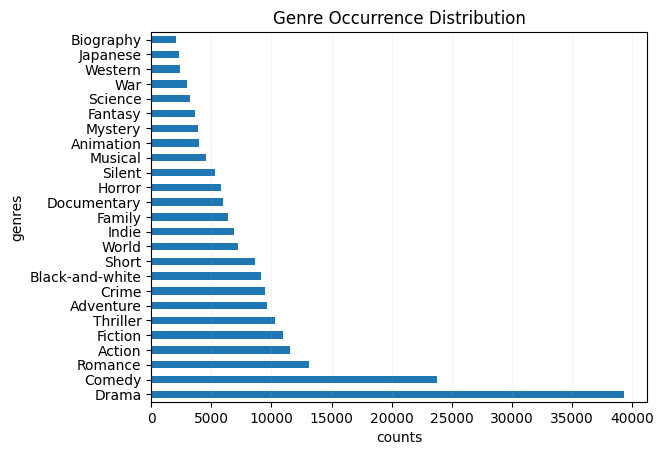

In [100]:
def unify_genres(x):
    try:
        unified_genres = set()
        for genre in x:
            themes_in_genres = {t for t in new_genres if genre in genres_dict[t]}
            unified_genres = unified_genres.union(themes_in_genres)
        return unified_genres if unified_genres else np.nan

    except TypeError:
        return x


movies["genres"] = movies["combinedGenres"].apply(unify_genres)
# movies.drop(columns=["genresCmu","genresImdb","combinedGenres"],inplace=True) #TODO uncomment

occurences = movies["genres"].explode().value_counts()
occurences.plot(kind="barh")
plt.title("Genre Occurrence Distribution")
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

percent_missing = movies["genres"].isnull().sum() / len(movies)
print(f"Proportion of missing values in column genres {percent_missing:.2%}")

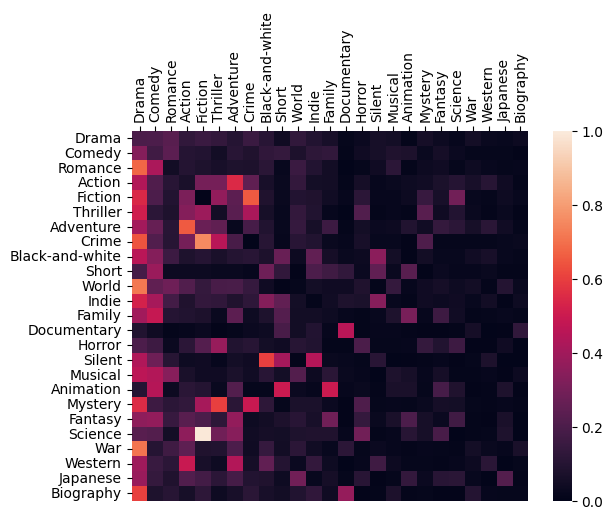

In [101]:
# Explode the genres and get dummies
genre_dummies = pd.get_dummies(movies["genres"].explode())
genre_dummies.index.name = "index"

# Group by index and sum
genre_dummies_grouped = genre_dummies.groupby("index").sum()

# Get the list of genres
genres_list = movies["genres"].explode().dropna().value_counts().index.to_list()

# Initialize co-occurrences matrix
co_occurrences_matrix = np.zeros((len(genres_list), len(genres_list)))

# Calculate co-occurrences
for x, genre_x in enumerate(genres_list):
    for y, genre_y in enumerate(genres_list):
        if genre_x == genre_y:
            co_occurrences_matrix[x, y] = (
                    movies["genres"].apply(lambda x: x == {genre_x}).sum()
                    / genre_dummies_grouped[genre_x].sum()
            )
        else:
            co_occurrences_matrix[x, y] = (
                                                  (genre_dummies_grouped[genre_x] + genre_dummies_grouped[genre_y]) == 2
                                          ).sum() / genre_dummies_grouped[genre_x].sum()

# Plot heatmap
heatmap_ax = sns.heatmap(
    co_occurrences_matrix,
    xticklabels=genres_list,
    yticklabels=genres_list,
    vmax=1,
    vmin=0,
)

# Move x-axis to top and rotate labels
heatmap_ax.xaxis.tick_top()
plt.xticks(rotation=90);

# CHANTIER EN COURS

In [102]:
actors_exploded = explode_on_movies(actors)

In [103]:
# Merge actors_genres with movies dataset, explode the genres column
merged_actors_genres = actors_exploded.merge(movies[["fbID", "genres"]], how="left", on="fbID")
exploded_actors_genres = merged_actors_genres[["fbActorID", "fbID", "genres"]].explode(column="genres")

# Create dummy variables for genres and group and sum 
genre_dummies = pd.get_dummies(exploded_actors_genres, columns=["genres"], prefix="", prefix_sep="")
grouped_genre_dummies = (1 * genre_dummies).groupby(["fbActorID", "fbID"]).sum()

# Calculate the sum of genres for each actor and movie
grouped_genre_dummies["genresCounts"] = grouped_genre_dummies[genres_list].sum(axis="columns")

# Normalize by dividing by the total count of genres
normalized_genre_dummies = grouped_genre_dummies.div(grouped_genre_dummies["genresCounts"], axis=0)

# Group by fbActorID and sum again
grouped_normalized_genre_dummies = normalized_genre_dummies.groupby("fbActorID").sum()

# Filter actors with at least 100 genresCounts
filtered_genre_dummies = grouped_normalized_genre_dummies.query("genresCounts >= 10")

# Normalize again after filtering
final_genre_dummies = filtered_genre_dummies.div(filtered_genre_dummies["genresCounts"], axis=0)

# Group by fbActorID and sum again
final_grouped_genre_dummies = final_genre_dummies.groupby("fbActorID").sum()


In [104]:
len(final_grouped_genre_dummies)

9318

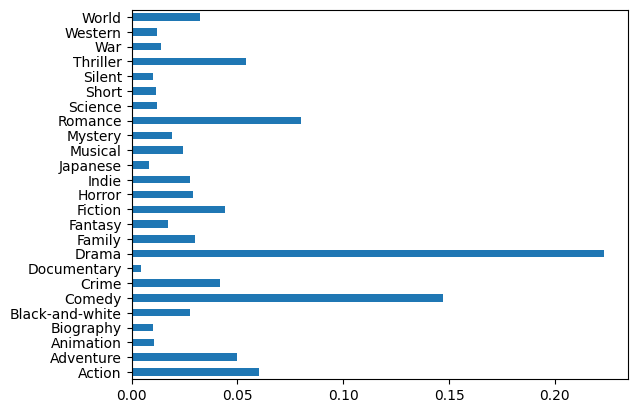

In [105]:
final_grouped_genre_dummies.drop(columns=["genresCounts"]).mean(axis="index").plot(kind="barh");

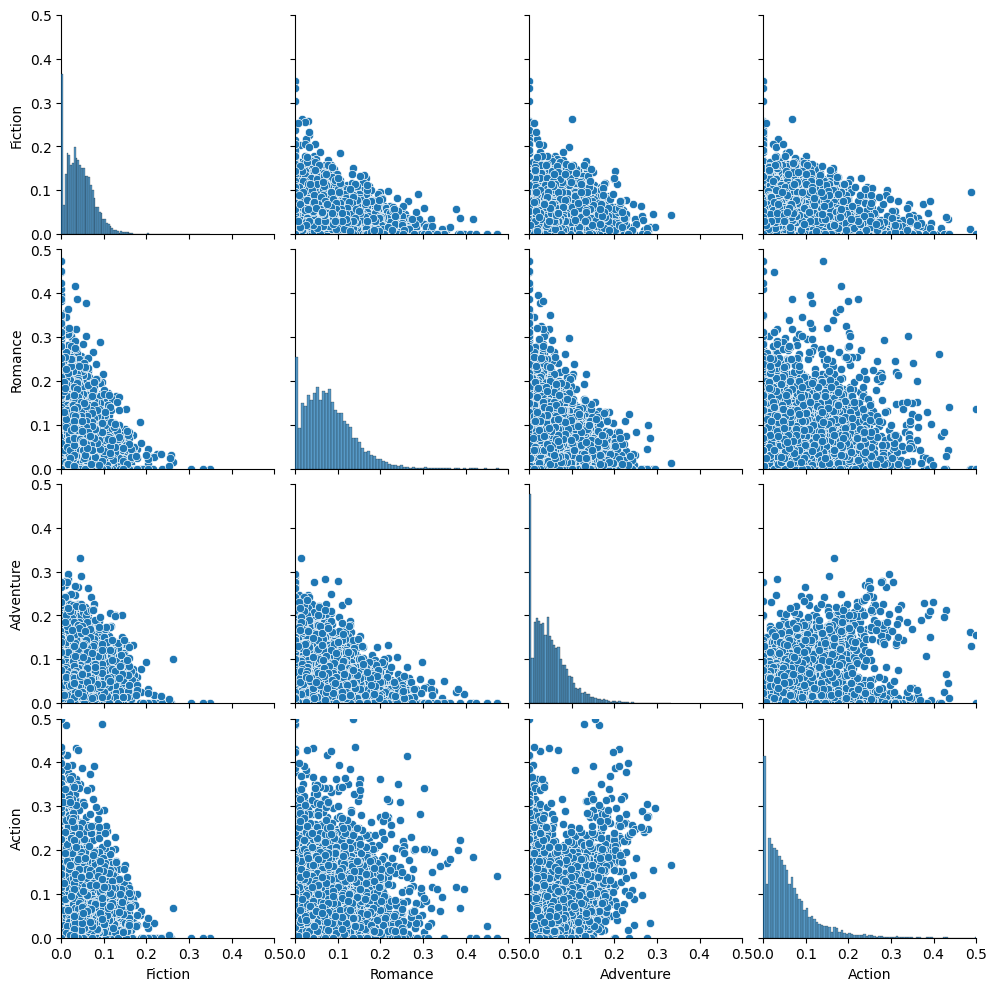

In [111]:
pairplot = sns.pairplot(
    final_grouped_genre_dummies[["Fiction", "Romance", "Adventure", "Action"]],
)
pairplot.set(ylim=[0, 0.5], xlim=[0, 0.5])

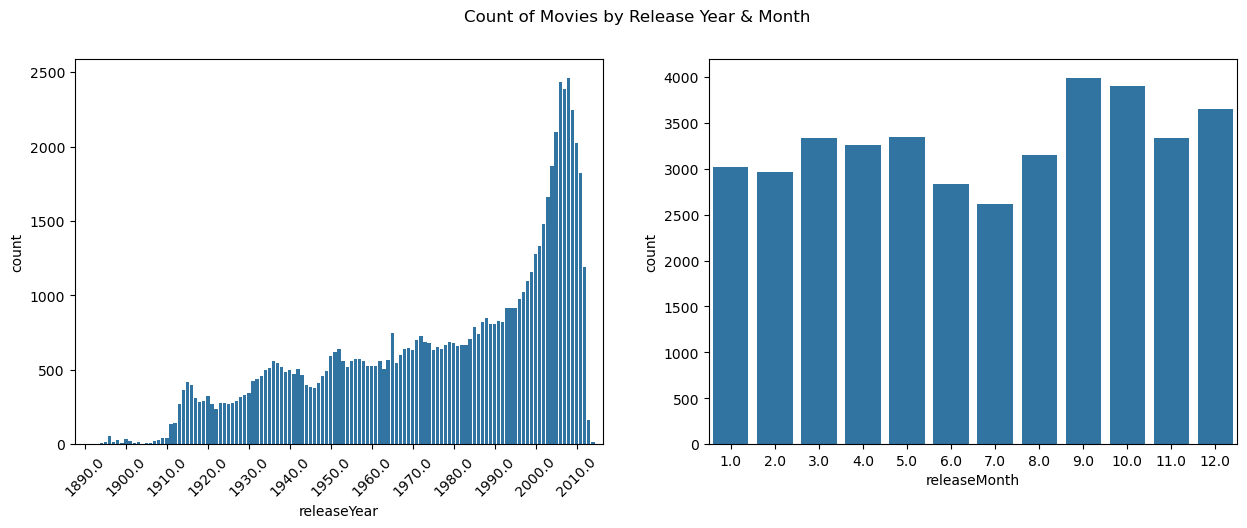

In [31]:
# Je sais pas pourquoi tes couleurs sont parties Valerie
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Count of Movies by Release Year & Month')

fig.add_subplot(121)
sns.countplot(x='releaseYear', data=movies_load)
plt.xticks(plt.xticks()[0][2::10], rotation=45)

fig.add_subplot(122)
sns.countplot(x="releaseMonth", data=movies_load)

plt.subplots_adjust(wspace=0.2)
plt.show()

# FIN DU CHANTIER

## Saving Preprocessed Datasets

### Removing Unnecessary Columns

We are excluding columns containing information irrelevant to our analysis from all datasets to optimize memory usage and enhance readability.

In [107]:
# TODO enlever toutes les columns qu'on utilise pas dans TOUS les datasets

In [217]:
movies.to_csv(DATA_FOLDER + "movies.csv", index=False)
actors.to_csv(DATA_FOLDER + "actors.csv", index=False)

In [40]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

## Career Trajectory Analysis - Jennifer (should probably be before Genre analysis)

In [63]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [64]:
print("Total number of actors:", actors_load.shape[0])

Total number of actors: 135760


There are 135'760 actors in our dataset. It is likely that the dataset contains a diverse range of individuals with varying levels of involvement in the film industry, including many actors who have only appeared in a few movies ("one-timers" or relatively minor contributors to the overall landscape of the industry). Let us look at the number of movies played by the actors to confirm that.

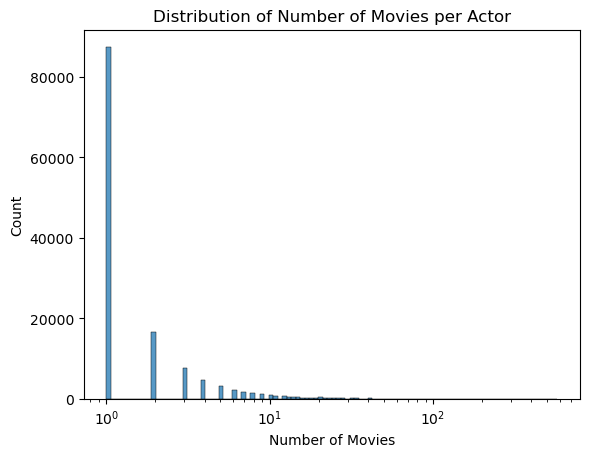

Number of actors that have played in only one movie: 87320
Number of actors that have played in less than 10 movies: 126320


In [65]:
actors_load['numMovies'] = actors_load['fbID'].apply(lambda x: len(x))

sns.histplot(data=actors_load, x='numMovies', bins=100, log_scale=True)
plt.title("Distribution of Number of Movies per Actor")
plt.xlabel("Number of Movies")
plt.ylabel("Count")
plt.show()

num_actors_one_movie = (actors_load['numMovies'] == 1).sum()
print(f"Number of actors that have played in only one movie: {num_actors_one_movie}")
num_actors_ten_movies = (actors_load['numMovies'] < 10).sum()
print(f"Number of actors that have played in less than 10 movies: {num_actors_ten_movies}")

#TODO Choose number of minimum number of movies played by actors 
# Do we all agree with 10, because we are technically removing a LOT of actors?

We observe that a significant proportion of actors have contributed to fewer than 10 movies. For the purpose of our analysis, we have chosen to exclude these actors from consideration to focus on individuals with more extensive careers. 

The distribution of the number of movies per actor now is:

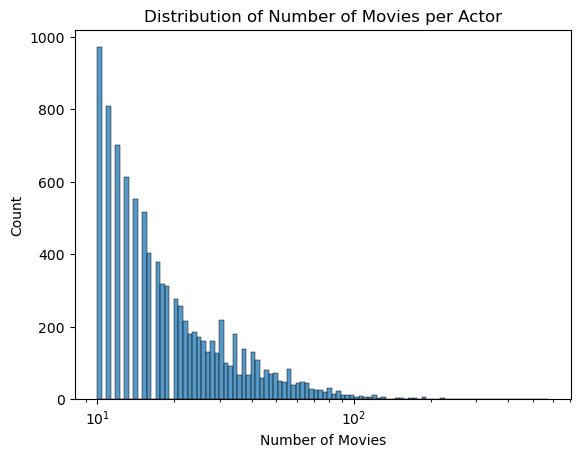

In [66]:
actors_load = actors_load[actors_load['numMovies'] >= 10]
sns.histplot(data=actors_load, x='numMovies', bins=100, log_scale=True)
plt.title("Distribution of Number of Movies per Actor")
plt.xlabel("Number of Movies")
plt.ylabel("Count")
plt.show()

Let us now look at the year of birth of the actors considered.

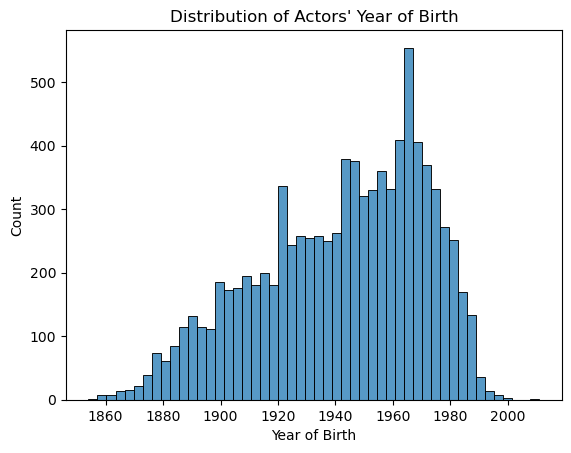

The minimum year of birth is 1854.0 and the maximum year of birth is 2011.0.


In [67]:
actors_load['actorDOB'] = pd.to_datetime(actors_load['actorDOB'])
actors_load['yearOfBirth'] = actors_load['actorDOB'].dt.year

# Plot histogram
sns.histplot(data=actors_load, x='yearOfBirth', bins=50)
plt.title("Distribution of Actors' Year of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.show()

min_year = actors_load['yearOfBirth'].min()
max_year = actors_load['yearOfBirth'].max()

print(f"The minimum year of birth is {min_year} and the maximum year of birth is {max_year}.")


From 1854 to 1970, there appears to be a noticeable increase in the number of actors born during this period. This rise could be indicative of several factors, such as the increasing popularity of movies as a form of entertainment, the growth of the film industry, and the increasing recognition of acting as a viable and esteemed profession. A decrease in the number of actors can be noticed after 1975, which can be explained by the fact that some 'future' actors may have not started their career yet.

Let us now see if there is a difference in this distribution depending on the gender.

Number of female actors: 3183
Number of male actors: 6237
Percentage of female actors: 33.789808917197455


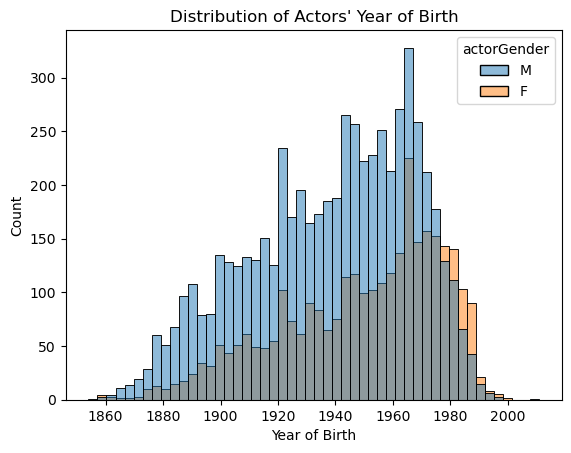

In [68]:
num_female_actors = actors_load['actorGender'].value_counts()['F']
num_male_actors = actors_load['actorGender'].value_counts()['M']

print("Number of female actors:", num_female_actors)
print("Number of male actors:", num_male_actors)
print("Percentage of female actors:", 100 * num_female_actors / (num_female_actors + num_male_actors))

# Plot histogram
sns.histplot(data=actors_load, x='yearOfBirth', bins=50, hue='actorGender')
plt.title("Distribution of Actors' Year of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.show()

There is a larger number of male actors than female actors. However, it seems that the proportion of female actors is increasing with time. 

Excluding the tails, specifically the lower and upper 10% of the interval, we can visualize the evolution of female actors, which is indeed increasing. This exclusion can be justified by the consideration that some actors may not have yet started their careers, particularly those entering the industry after 1990. By focusing on the central portion of the data, we aim to provide a more accurate depiction of the evolving gender composition among actors over the relevant time frame.

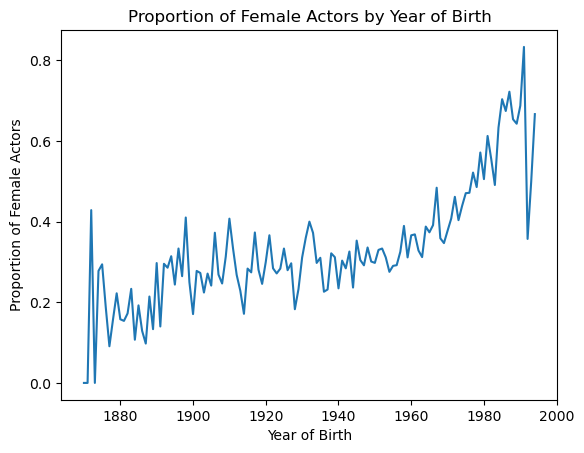

In [69]:
# group actors by year of birth and calculate proportion of female actors
prop_female_actors = \
    actors_load[(actors_load['yearOfBirth'] >= 1870) & (actors_load['yearOfBirth'] <= 1995)].groupby('yearOfBirth')[
        'actorGender'].apply(lambda x: (x == 'F').sum() / len(x))

# plot the proportion of female actors per year of birth
plt.plot(prop_female_actors.index, prop_female_actors.values)
plt.xlabel('Year of Birth')
plt.ylabel('Proportion of Female Actors')
plt.title('Proportion of Female Actors by Year of Birth')
plt.show()

We now want to analyze the career start ages of actors. This will be determined by calculating the age at which an actor first appears in a movie within our dataset. To ensure an accurate assessment of career beginnings and to avoid erroneously identifying a mid-career movie as the initial one due to a lack of data before it, we will consider actors born after the release year of the earliest movie included in our dataset.

In [70]:
print('Minimum release year for movies dataset: ', movies_load['releaseYear'].min())
actors_after_1888 = actors_load[actors_load['yearOfBirth'] > 1888]
print('Number of actors after 1888: ', actors_after_1888.shape[0])

Minimum release year for movies dataset:  1888.0
Number of actors after 1888:  8561


In [75]:
# Define a function to extract the minimum age from the ageAtMovieRelease dictionary
def get_min_age(x):
    if isinstance(x, dict):
        return min(x.values())
    else:
        return np.nan


# Apply the function to the ageAtMovieRelease column
actors_after_1888['ageAtFirstMovie'] = actors_after_1888['ageAtMovieRelease'].apply(get_min_age)


The mean age at first movie appearance is 25.35 years old.
The median age at first movie appearance is 25.00 years old.
Minimum age at first movie appearance: -50.0
Maximum age at first movie appearance: 75.0


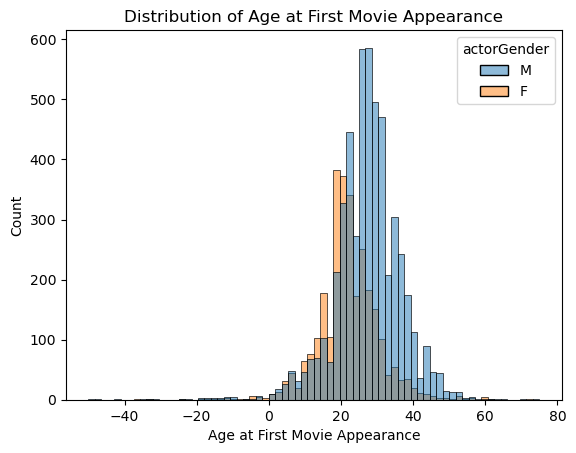

In [76]:
# Statistics on age at first movie appearance
mean_age = actors_after_1888['ageAtFirstMovie'].mean()
median_age = actors_after_1888['ageAtFirstMovie'].median()

print(f"The mean age at first movie appearance is {mean_age:.2f} years old.")
print(f"The median age at first movie appearance is {median_age:.2f} years old.")
print("Minimum age at first movie appearance:", actors_after_1888['ageAtFirstMovie'].min())
print("Maximum age at first movie appearance:", actors_after_1888['ageAtFirstMovie'].max())

# Plot histogram of age at first movie appearance
sns.histplot(data=actors_after_1888, x='ageAtFirstMovie', bins=70, hue='actorGender')
plt.title("Distribution of Age at First Movie Appearance")
plt.xlabel("Age at First Movie Appearance")
plt.ylabel("Count")
plt.show()

Based on the observed distributions, it appears that there is a discrepancy in the age at which individuals of different genders make their first movie appearances, with male actors seemingly starting at an older age compared to female actors. To formally test this observation, we can conduct a t-test with the null hypothesis that the mean age at first movie for both genders is equal, which will help confirm whether the observed difference is statistically significant or could be due to random chance.

In [81]:
men_data = actors_after_1888.loc[actors_after_1888['actorGender'] == 'M', 'ageAtFirstMovie']
women_data = actors_after_1888.loc[actors_after_1888['actorGender'] == 'F', 'ageAtFirstMovie']

# Perform the t-test
t_stat, p_value = ttest_ind(men_data.dropna(), women_data.dropna(), equal_var=False, alternative='greater')

# Print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 26.62
p-value: 0.00


Given the p-value of 0.00, it is extremely unlikely to observe such a large difference in age at first movie appearance between men and women if there were no true difference in the population. Therefore, we may reject the null hypothesis. It can thus be suggested that the age at which male actors make their first movie appearance is statistically significantly greater than that of female actors.

Text(0, 0.5, 'Mean Age at First Movie Appearance')

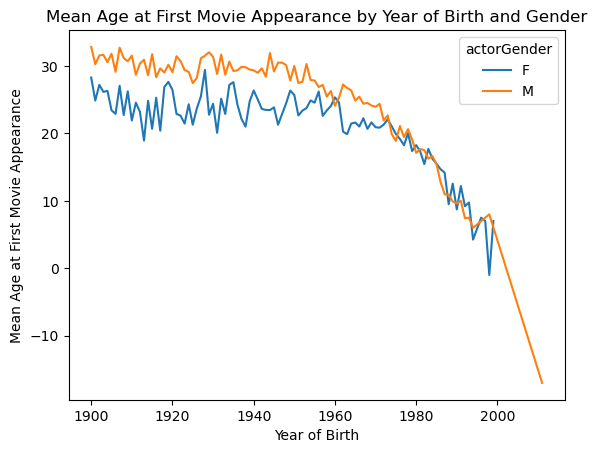

In [85]:
# Group actors by year of birth and gender and calculate mean age at first movie appearance
mean_age_by_year_gender = actors_after_1888.groupby(['yearOfBirth', 'actorGender'])[
    'ageAtFirstMovie'].mean().reset_index()

# Plot mean age at first movie appearance per year of birth and gender
sns.lineplot(data=mean_age_by_year_gender, x='yearOfBirth', y='ageAtFirstMovie', hue='actorGender')
plt.title('Mean Age at First Movie Appearance by Year of Birth and Gender')
plt.xlabel('Year of Birth')
plt.ylabel('Mean Age at First Movie Appearance')

#TODO We really have to solve this problem of age 
#TODO Once this is solved, do analysis on this (can we say that there is no difference from a 
# certain year because gender equality and all)

In [98]:
print('Maximum release year for movies dataset: ', movies_load['releaseYear'].max())
actors_full_career = actors_after_1888[actors_after_1888['yearOfBirth'] < 2017 - 61]
#TODO: discuss with someone about this choice
print('Number of actors between 1888 and 1967: ', actors_full_career.shape[0])

Maximum release year for movies dataset:  2016.0
Number of actors between 1888 and 1967:  5038


In [99]:
# Define a function to extract the maximum age from the ageAtMovieRelease dictionary
def get_max_age(x):
    if isinstance(x, dict):
        return max(x.values())
    else:
        return np.nan


# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtLastMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_max_age)
# Calculate career length
actors_full_career['careerLength'] = actors_full_career['ageAtLastMovie'] - actors_full_career['ageAtFirstMovie']

To choose the upper limit for the birth years of actors, we conducted an analysis of the age at the last movie appearance within a specified interval that should be immune to the influence of cutting points (taking into account a 100-year margin). The results revealed an average age of approximately 60.96 years, which thus taken off from 2017, last movie release year in our dataset.

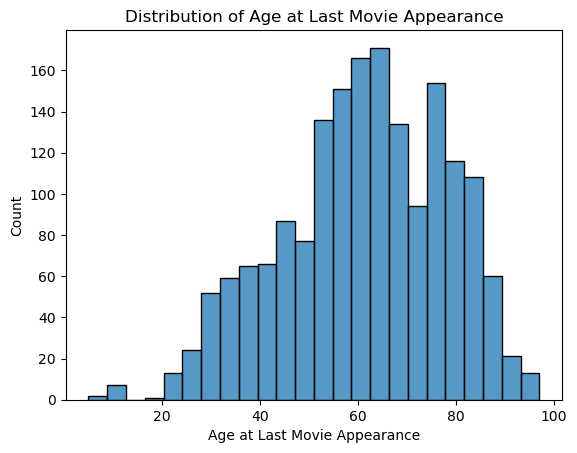

Mean age at last movie appearance: 60.96
Median age at last movie appearance: 62.00


In [95]:
# Mean and median of age at last movie appearance
age_last_movie = actors_full_career[actors_full_career.yearOfBirth < 2017 - 90]['ageAtLastMovie']
print(f"Mean age at last movie appearance: {age_last_movie.mean():.2f}")
print(f"Median age at last movie appearance: {age_last_movie.median():.2f}")

# Plot histogram of age at last movie appearance
sns.histplot(data=actors_full_career[actors_full_career.yearOfBirth < 2017 - 90], x='ageAtLastMovie')
plt.title('Distribution of Age at Last Movie Appearance')
plt.xlabel('Age at Last Movie Appearance')
plt.ylabel('Count')
plt.show()

The mean career length is 32.61 years.
The median career length is 32.00 years.


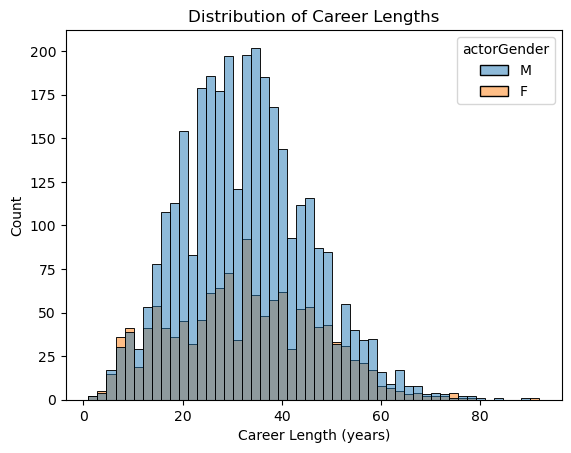

In [102]:
mean_career_length = actors_full_career['careerLength'].mean()
median_career_length = actors_full_career['careerLength'].median()

print(f"The mean career length is {mean_career_length:.2f} years.")
print(f"The median career length is {median_career_length:.2f} years.")

sns.histplot(data=actors_full_career, x='careerLength', bins=50, hue='actorGender')
plt.title("Distribution of Career Lengths")
plt.xlabel("Career Length (years)")
plt.ylabel("Count")
plt.show()


A t-test was conducted to assess whether there is a statistically significant difference in the career lengths between male and female actors.

In [104]:
# extract career lengths for male and female actors
male_career_lengths = actors_full_career[actors_full_career['actorGender'] == 'M']['careerLength']
female_career_lengths = actors_full_career[actors_full_career['actorGender'] == 'F']['careerLength']

# perform the t-test
t_stat, p_value = ttest_ind(male_career_lengths.dropna(), female_career_lengths.dropna(), equal_var=False)

# print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 0.41
p-value: 0.68


The t-statistic of 0.41 suggests a relatively small difference in means between the two groups. The p-value of 0.68 is above the significance threshold 0.05, indicating that there is insufficient evidence to reject the null hypothesis. In other words, the observed difference in the meands of career lengths between male and female actors is not statistically significant.

#TODO: same means but distribution looks different, that's weird

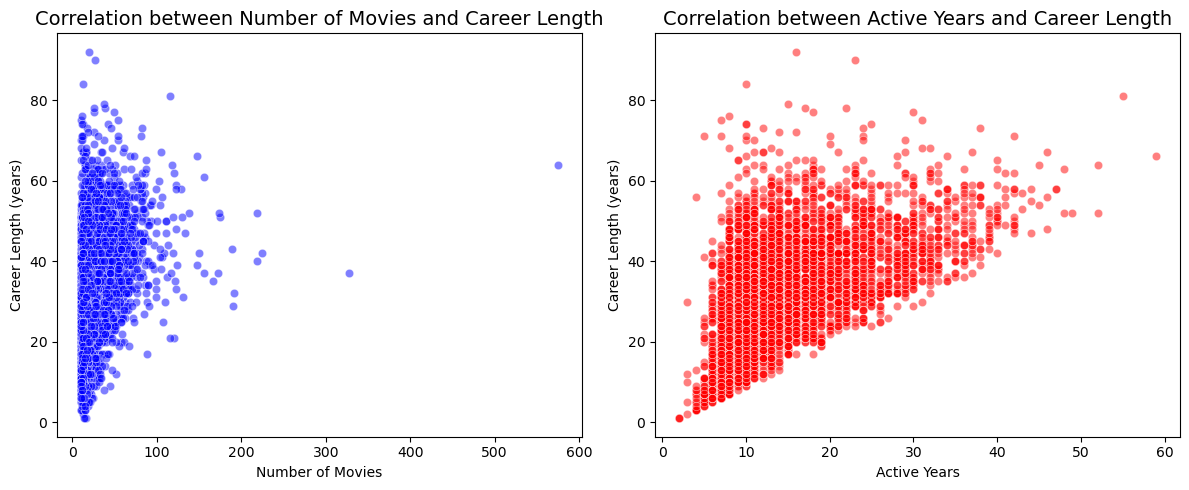

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=actors_full_career, x='numMovies', y='careerLength', ax=ax1, color='blue', alpha=0.5)
ax1.set_title("Correlation between Number of Movies and Career Length", fontsize=14)
ax1.set_xlabel("Number of Movies")
ax1.set_ylabel("Career Length (years)")

# Extract unique age values from ageAtMovieRelease dictionary
#TODO: Explain what is active years
actors_full_career['activeYears'] = actors_full_career['ageAtMovieRelease'].apply(
    lambda x: len(set(x.values())) if isinstance(x, dict) else np.nan)

sns.scatterplot(data=actors_full_career, x='activeYears', y='careerLength', ax=ax2, color='red', alpha=0.5)
ax2.set_title("Correlation between Active Years and Career Length", fontsize=14)
ax2.set_xlabel("Active Years")
ax2.set_ylabel("Career Length (years)")

plt.tight_layout()
plt.show()

#TODO: Interpretation de ces plots

In [111]:
# Calculate average number of movies per year
actors_full_career['avgMoviesPerYear'] = actors_full_career['numMovies'] / actors_full_career['careerLength']

# Calculate active years per career length
actors_full_career['activeYearsPerCareerLength'] = actors_full_career['activeYears'] / actors_full_career[
    'careerLength']

#TODO: Do something out of this (potentially)